In [42]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.api.types import is_string_dtype, CategoricalDtype
#from keras.preprocessing.sequence import pad_sequences
#authors note, different version of Keras put pad_sequences in different places, if one doesn't work, please try the other
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils.data_utils import pad_sequences
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [43]:
#for google colab
#from google.colab import files
#uploaded = files.upload()

In [44]:
#for google colab
#from google.colab import files
#uploaded = files.upload()

In [45]:
country = 'Russia'

In [46]:
frdm = pd.read_csv("../data/fh.csv")
df = pd.read_parquet("../data/roberta_scored_data/russia_roberta_scores.parquet")

In [47]:
df.columns

Index(['abstract', 'headline', 'pub_date', 'year', 'section_name', 'news_desk',
       'keyword', 'label', 'all_text', 'roberta_scores', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
      dtype='object')

In [48]:
df.head()

,abstract,headline,pub_date,year,section_name,news_desk,keyword,label,all_text,roberta_scores,roberta_neg,roberta_neu,roberta_pos
0,The Kremlin’s continued prosecution of the Rus...,"Guilty Verdict for a Tycoon, and Russia",2011-01-01T01:13:03+0000,2011,Business Day,Business,Russia,decreasing,"Guilty Verdict for a Tycoon, and Russia The Kr...","[0.63768524, 0.35055304, 0.011761652]",0.637685,0.350553,0.011762
1,"With the New Start treaty nearly wrapped up, P...",The Next Treaties,2011-01-01T02:42:37+0000,2011,Opinion,Editorial,Russia,decreasing,The Next Treaties With the New Start treaty ne...,"[0.051770635, 0.88132036, 0.06690902]",0.051771,0.881320,0.066909
2,A Soviet-made airliner caught fire at an airpo...,"Russian Plane Catches Fire, Killing Three",2011-01-01T17:21:09+0000,2011,World,Foreign,Russia,decreasing,"Russian Plane Catches Fire, Killing Three A So...","[0.7689814, 0.22477503, 0.006243567]",0.768981,0.224775,0.006244
3,A Moscow court’s jailing of protesters despite...,Arrests in Russia Signal Divisions Over Dissent,2011-01-03T16:01:03+0000,2011,World,Foreign,Russia,decreasing,Arrests in Russia Signal Divisions Over Dissen...,"[0.62112474, 0.37140587, 0.0074693784]",0.621125,0.371406,0.007469
4,President Dmitri A. Medvedev of Russia has agr...,Israel: Strike Delays Russian Visit,2011-01-03T23:55:08+0000,2011,World,Foreign,Russia,decreasing,Israel: Strike Delays Russian Visit President ...,"[0.65579426, 0.3363528, 0.007852921]",0.655794,0.336353,0.007853


In [49]:
df = df[df['keyword'] == country]

In [50]:
frdm.head(3)

,Unnamed: 0,fh_country,year,pr,cl,status,fh_total,fh_total_reversed,extended_country_name,GWn,cown,in_GW_system
0,1,Afghanistan,1972,4,5,PF,9,5,Afghanistan,700,700,True
1,2,Afghanistan,1973,7,6,NF,13,1,Afghanistan,700,700,True
2,3,Afghanistan,1974,7,6,NF,13,1,Afghanistan,700,700,True


In [51]:
def select_country(frdm, country):
	frdm = frdm.rename(columns={'fh_country': 'country'})
	frdm_scores = frdm[frdm['country'] == country]
	return frdm_scores

In [52]:
frdm_scores = select_country(frdm, country)
frdm_scores.head()

,Unnamed: 0,country,year,pr,cl,status,fh_total,fh_total_reversed,extended_country_name,GWn,cown,in_GW_system
6425,6426,Russia,1991,3,3,PF,6,8,Russia (Soviet Union),365,365,True
6426,6427,Russia,1992,3,4,PF,7,7,Russia (Soviet Union),365,365,True
6427,6428,Russia,1993,3,4,PF,7,7,Russia (Soviet Union),365,365,True
6428,6429,Russia,1994,3,4,PF,7,7,Russia (Soviet Union),365,365,True
6429,6430,Russia,1995,3,4,PF,7,7,Russia (Soviet Union),365,365,True


In [53]:
df['pub_date'] = pd.to_datetime(df['pub_date'])
# First, filter df1 for rows where the country is 'egypt'
# Extract the year from the date in df2
df['year'] = df['pub_date'].dt.year

# Now, merge the two dataframes on the 'year' column
merged_df = pd.merge(df, frdm_scores[['fh_total', 'year']], on='year', how='left')

In [54]:
merged_df['fh_total'].value_counts()

fh_total
13.0    4289
12.0    2416
11.0    2107
Name: count, dtype: int64

In [55]:
merged_df.head()

,abstract,headline,pub_date,year,section_name,news_desk,keyword,label,all_text,roberta_scores,roberta_neg,roberta_neu,roberta_pos,fh_total
0,The Kremlin’s continued prosecution of the Rus...,"Guilty Verdict for a Tycoon, and Russia",2011-01-01 01:13:03+00:00,2011,Business Day,Business,Russia,decreasing,"Guilty Verdict for a Tycoon, and Russia The Kr...","[0.63768524, 0.35055304, 0.011761652]",0.637685,0.350553,0.011762,11.0
1,"With the New Start treaty nearly wrapped up, P...",The Next Treaties,2011-01-01 02:42:37+00:00,2011,Opinion,Editorial,Russia,decreasing,The Next Treaties With the New Start treaty ne...,"[0.051770635, 0.88132036, 0.06690902]",0.051771,0.881320,0.066909,11.0
2,A Soviet-made airliner caught fire at an airpo...,"Russian Plane Catches Fire, Killing Three",2011-01-01 17:21:09+00:00,2011,World,Foreign,Russia,decreasing,"Russian Plane Catches Fire, Killing Three A So...","[0.7689814, 0.22477503, 0.006243567]",0.768981,0.224775,0.006244,11.0
3,A Moscow court’s jailing of protesters despite...,Arrests in Russia Signal Divisions Over Dissent,2011-01-03 16:01:03+00:00,2011,World,Foreign,Russia,decreasing,Arrests in Russia Signal Divisions Over Dissen...,"[0.62112474, 0.37140587, 0.0074693784]",0.621125,0.371406,0.007469,11.0
4,President Dmitri A. Medvedev of Russia has agr...,Israel: Strike Delays Russian Visit,2011-01-03 23:55:08+00:00,2011,World,Foreign,Russia,decreasing,Israel: Strike Delays Russian Visit President ...,"[0.65579426, 0.3363528, 0.007852921]",0.655794,0.336353,0.007853,11.0


In [56]:
# Assuming df is your DataFrame and 'pub_date' is your date column
merged_df = merged_df.set_index('pub_date')

# Resample the data to daily frequency
df_daily = merged_df.resample('D').first()

# Fill the NaN values with 0
df_daily = df_daily.fillna(0)


In [57]:
df_daily.head()

,abstract,headline,year,section_name,news_desk,keyword,label,all_text,roberta_scores,roberta_neg,roberta_neu,roberta_pos,fh_total
pub_date,,,,,,,,,,,,,
2011-01-01 00:00:00+00:00,The Kremlin’s continued prosecution of the Rus...,"Guilty Verdict for a Tycoon, and Russia",2011.0,Business Day,Business,Russia,decreasing,"Guilty Verdict for a Tycoon, and Russia The Kr...","[0.63768524, 0.35055304, 0.011761652]",0.637685,0.350553,0.011762,11.0
2011-01-02 00:00:00+00:00,0,0,0.0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0
2011-01-03 00:00:00+00:00,A Moscow court’s jailing of protesters despite...,Arrests in Russia Signal Divisions Over Dissent,2011.0,World,Foreign,Russia,decreasing,Arrests in Russia Signal Divisions Over Dissen...,"[0.62112474, 0.37140587, 0.0074693784]",0.621125,0.371406,0.007469,11.0
2011-01-04 00:00:00+00:00,"With $50 million, DST Global raises its stake ...",Russians’ Large Stake in Facebook Grows Larger,2011.0,Business Day,,Russia,decreasing,Russians’ Large Stake in Facebook Grows Larger...,"[0.006580864, 0.6556678, 0.33775136]",0.006581,0.655668,0.337751,11.0
2011-01-05 00:00:00+00:00,0,0,0.0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.0


In [58]:
df_daily['all_text'] = df_daily['all_text'].replace(0, 'no_news')
df_daily['all_text'] = df_daily['all_text'].apply(lambda x: x.split())

# Convert the column of lists into a single list of sentences
sentences = df_daily['all_text'].tolist()


train word vectors

In [59]:
# Word2Vec
word2vec = Word2Vec(sentences, vector_size=120, window=5, min_count=1, workers=4)
word2vec.train(sentences, total_examples=len(sentences), epochs=10)

(1049066, 1286800)

Create target column

In [61]:
target = df_daily['fh_total']
target.replace(0, np.nan, inplace=True)
target.bfill(inplace=True)
target.ffill(inplace=True)
target.value_counts()

fh_total
13.0    2922
11.0    1096
12.0     730
Name: count, dtype: int64

In [ ]:
#df.columns
columns = df_daily.columns[df_daily.columns.str.contains('bert|vader')]
df_selected = df_daily[columns]


In [62]:
# Word2Vec => tokenize my words to prep for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
data = pad_sequences(sequences)

# Prepare target variable (freedom scores)
# ... (your code here)
print(data.shape)
print(target.shape)

(4748, 87)
(4748,)


In [63]:
def expand_features(full_array, window=50):

    n_features = full_array.shape[1]
    

    expanded_features = np.zeros((full_array.shape[0], n_features * window))
    for feature_idx in range(n_features):
        # For each time step in the window
        for lag in range(window):
            # Shift the data
            shifted_data = np.roll(full_array[:, feature_idx], lag)
            # Set the first 'lag' values to zero
            shifted_data[:lag] = 0
            # Store it in the expanded features
            expanded_features[:, feature_idx*window + lag] = shifted_data
            
    return expanded_features

In [64]:
expanded_data = expand_features(data, 50)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(expanded_data, target, test_size=0.2, random_state=42)

Find word similarities

In [67]:
word_vectors = word2vec.wv.vectors
# Create a word-to-index dictionary
word_to_index = {word: i for i, word in enumerate(word2vec.wv.index_to_key)}

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_to_index) + 1, word2vec.vector_size))
for word, i in word_to_index.items():
    embedding_matrix[i] = word2vec.wv[word]



In [70]:
from tensorflow.keras.layers import Bidirectional
# Define LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index) + 1, output_dim=word2vec.vector_size, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))  # More units, return sequences for stacking
model.add(Dropout(.1))  # Dropout for regularization
model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='tanh')))  # More units, return sequences for stacking
model.add(Dropout(.1))  # Dropout for regularization
model.add(Dense(1, activation='linear'))

# Compile the model with gradient clipping
opt = Adam(clipvalue=0.5)
model.compile(optimizer=opt, loss='mean_squared_error')

In [71]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(expanded_data, target, epochs=5, validation_split=0.2, batch_size=128, verbose=1)

Epoch 1/5
30/30 [==============================] - 720s 23s/step - loss: 29.4526 - val_loss: 0.0355
Epoch 2/5
30/30 [==============================] - 1109s 37s/step - loss: 1.1661 - val_loss: 0.6244
Epoch 3/5
 5/30 [====>.........................] - ETA: 24:17 - loss: 0.9810

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

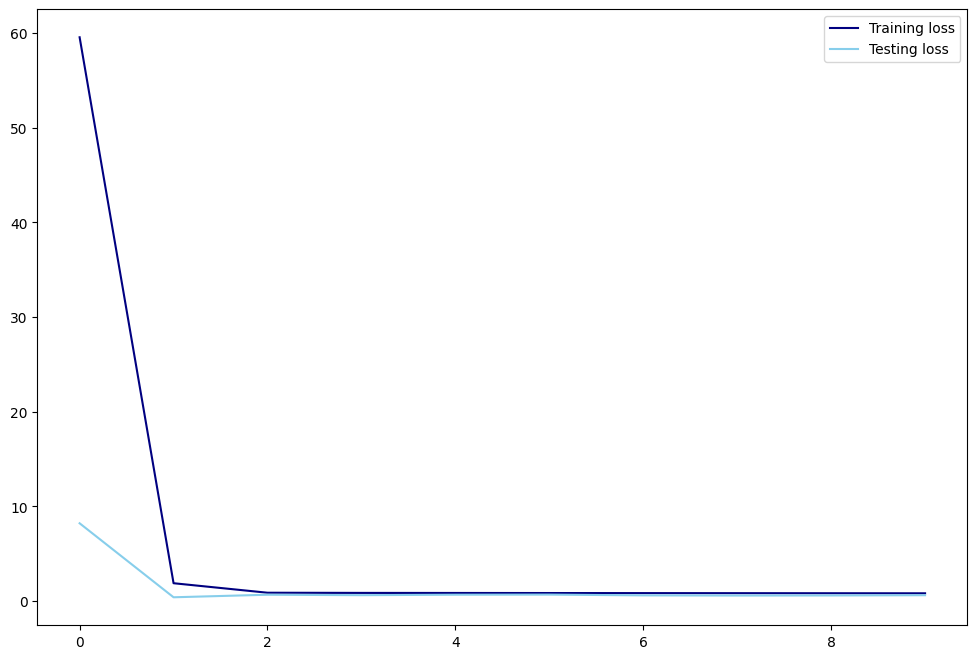

In [ ]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [ ]:
# Get the embeddings from the embedding layer
embeddings = model.layers[0].get_weights()[0]

# Create a dictionary to map indices to words
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_to_index.items()}

# Now you can get the embedding of a word like this:
word = "example"
word_embedding = embeddings[word_to_index[word]]

In [ ]:
word_embedding

array([-0.02270818,  0.04638885, -0.00918608,  0.01880567,  0.02911003,
        0.00385864,  0.04770538, -0.01647489,  0.03811292, -0.04402161,
        0.00353162, -0.02625338, -0.04556441, -0.02418173,  0.03292876,
       -0.01646582,  0.02826924, -0.02207358, -0.04334329, -0.01394787,
        0.00198222, -0.01082713,  0.03528147,  0.02123004, -0.02284766,
        0.02744615,  0.04507652,  0.02539293, -0.00047426, -0.00055699,
       -0.04064018, -0.03228501, -0.0488784 ,  0.02343431, -0.00450666,
        0.01546543,  0.02649575, -0.03827449,  0.01888963,  0.0263534 ,
        0.02175152,  0.01311486,  0.03050259,  0.01900692,  0.0045494 ,
        0.02324464,  0.03395399,  0.01961519, -0.02793471,  0.00659522,
        0.04125473, -0.04515826,  0.01943357, -0.01864521, -0.02914256,
       -0.01288458,  0.03055224,  0.03107135,  0.00040753, -0.01992688,
        0.02807276,  0.0238966 , -0.03495276, -0.01783298,  0.00265012,
        0.0165749 ,  0.00904882, -0.03521918,  0.01849625, -0.02